## Meta Learners

In [1]:
from dowhy import CausalModel
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import psutil
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import graphviz
import networkx as nx
from lightgbm import LGBMRegressor
import econml
from matplotlib import pyplot as plt
from toolz import curry

In [2]:
@curry
def elast(data, y, t):
    return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
            np.sum((data[t] - data[t].mean())**2))

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

In [3]:
# Get the virtual memory details
memory_info = psutil.virtual_memory()
total_memory = memory_info.total
available_memory = memory_info.available
used_memory = memory_info.used

print(f"Total Memory: {total_memory / (1024 ** 3):.2f} GB")
print(f"Available Memory: {available_memory / (1024 ** 3):.2f} GB")
print(f"Used Memory: {used_memory / (1024 ** 3):.2f} GB")

Total Memory: 7.45 GB
Available Memory: 0.94 GB
Used Memory: 6.51 GB


In [4]:
df = pd.read_csv("./Final Data/analysis_input.csv")
df = df.dropna(subset=['overlap']).dropna()

In [5]:
df['branch_closures_tract_binary'] = [1 if x>0 else 0 for x in df['branch_closures_tract'] ]

In [6]:
# Step 2: Create event_year variable
df['event_year'] = df['year'] - df['EFFDATE']

# Step 3: Preserve, then generate close_2yr
df['close_2yr'] = 0
df.loc[((df['event_year'] == 0) | (df['event_year'] == 1)), 'close_2yr'] = df['branch_closures_tract_binary'] #(df['event_year'] == 0) | 

# Collapse (taking max of 'close_2yr') and group by relevant columns
df_collapsed = df.groupby(['state', 'county', 'tract', 'overlap', 'mergerID']).agg({'close_2yr': 'max'}).reset_index()
tempclose2 = df_collapsed.copy()
# Merge the collapsed dataframe back into the original one
df.drop(columns=['close_2yr'], inplace=True)
df = df.merge(tempclose2, on=['state', 'county', 'tract', 'overlap', 'mergerID'], how='left')

In [7]:
# Step 4: Generate POST, POST_close, and POST_expose variables
df['POST'] = (df['event_year'] > 0).astype(int)
df['POST_close'] = df['POST'] * df['close_2yr']
df['POST_expose'] = df['POST'] * df['overlap']

# Step 4: Generate year dummies (ydum1999 to ydum2013)
for year in range(2010, 2023):
    df[f'ydum{year}'] = (df['year'] == year).astype(int)
    
# Step 5: Interact control variables with year dummies
control_vars = ['poptot', 'popden', 'pminority', 'pcollege', 'medincome', 'total_branches_county', 'avg_branch_growth_county']


# Step 7: Create group variables
df['group_timeID'] = pd.Categorical(pd.factorize(df[['state', 'county', 'year']].apply(tuple, axis=1))[0])
df['indivID'] = pd.Categorical(pd.factorize(df[['state', 'county', 'tract']].apply(tuple, axis=1))[0])
df['clustID'] = pd.Categorical(pd.factorize(df[['state', 'county']].apply(tuple, axis=1))[0])

In [8]:
def demean(df, group_vars, vars_to_demean):
    """
    Demean variables by group variables (fixed effects).
    
    Args:
        df (pd.DataFrame): The dataframe containing the data.
        group_vars (list of str): List of column names representing the fixed effect variables.
        vars_to_demean (list of str): List of variables to demean.
        
    Returns:
        df_demeaned (pd.DataFrame): DataFrame with demeaned variables.
    """
    df_demeaned = df.copy()
    
    # Group by the fixed effect variables and calculate group means
    group_means = df.groupby(group_vars, observed=True)[vars_to_demean].transform('mean')
    
    # Subtract the group means from the original variables to demean
    df_demeaned[vars_to_demean] = df[vars_to_demean] - group_means
    
    return df_demeaned

In [9]:
# Example usage:

# List of variables to demean (dependent variable, endogenous variable, exogenous variables)
vars_to_demean = ['sbl_total', 'vol_sbus', 'sbl_total_num', 'num_sbus','mortgage'] + control_vars


# Demean the dataset by indivID and group_timeID
df_demeaned = demean(df, 'indivID', vars_to_demean)

df_final = demean(df_demeaned, 'group_timeID', vars_to_demean)

In [10]:
df_dowhy = df_final.dropna(subset = ['branch_closures_tract_binary', 'total_branches_tract', 'sbl_total', 'POST_close', 'POST_expose'] + control_vars)

### S-Learner

In [11]:
from sklearn.model_selection import train_test_split
seed = 666

# Split the data
train, test = train_test_split(df_dowhy, test_size=0.2, random_state=seed)


In [12]:
y = "POST_close" #branch_closures_tract
T = "POST_expose"
X = control_vars

In [13]:
np.random.seed(seed)
s_learner = LGBMRegressor(max_depth=3, min_child_samples=30)
s_learner.fit(train[X+[T]], train[y])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1690
[LightGBM] [Info] Number of data points in the train set: 3444, number of used features: 8
[LightGBM] [Info] Start training from score 0.141405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LGBMRegressor(max_depth=3, min_child_samples=30)

In [14]:
s_learner_cate_train = (s_learner.predict(train[X].assign(**{T: 1})) -
                        s_learner.predict(train[X].assign(**{T: 0})))

s_learner_cate_test = test.assign(
    cate=(s_learner.predict(test[X].assign(**{T: 1})) - # predict under treatment
          s_learner.predict(test[X].assign(**{T: 0}))) # predict under control
)

In [15]:
s_learner_cate_train.mean()

Text(0.5, 1.0, 'S-Learner')

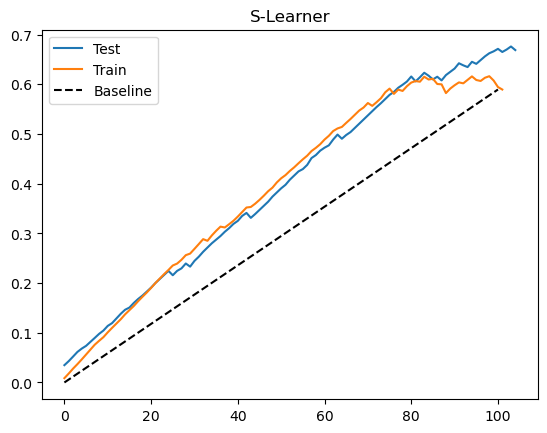

In [16]:
gain_curve_test = cumulative_gain(s_learner_cate_test, "cate", y=y, t=T)
gain_curve_train = cumulative_gain(train.assign(cate=s_learner_cate_train), "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(train, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("S-Learner")

### T-Learner

In [17]:
m0 = LGBMRegressor(max_depth=3, min_child_samples=30)
m1 = LGBMRegressor(max_depth=3, min_child_samples=30)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

# estimate the CATE
t_learner_cate_train = m1.predict(train[X]) - m0.predict(train[X])
t_learner_cate_test = test.assign(cate=m1.predict(test[X]) - m0.predict(test[X]))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 9154, number of used features: 7
[LightGBM] [Info] Start training from score 0.064343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [18]:
t_learner_cate_train.mean()

C:\Users\yulon\AppData\Local\Temp\ipykernel_25356\1654623385.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /


Text(0.5, 1.0, 'T-Learner')

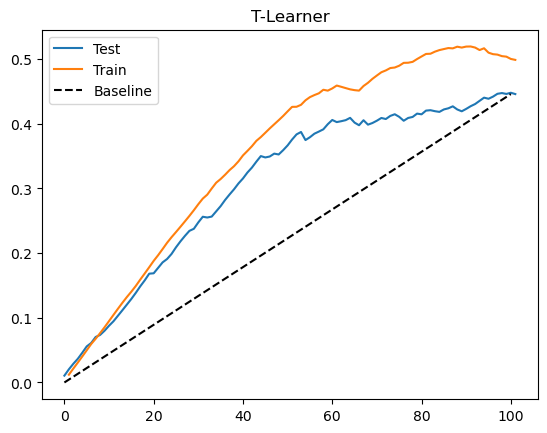

In [19]:
gain_curve_test = cumulative_gain(t_learner_cate_test, "cate", y=y, t=T)
gain_curve_train = cumulative_gain(train.assign(cate=t_learner_cate_train), "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("T-Learner")

### X-Learner

In [20]:
from sklearn.linear_model import LogisticRegression

np.random.seed(123)

# first stage models
m0 = LGBMRegressor(max_depth=3, min_child_samples=30)
m1 = LGBMRegressor(max_depth=3, min_child_samples=30)

# propensity score model
g = LogisticRegression(solver="lbfgs", penalty='none') 

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])
                       
g.fit(train[X], train[T])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 9154, number of used features: 7
[LightGBM] [Info] Start training from score 0.064343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\yulon\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(penalty='none')

In [21]:
d_train = np.where(train[T]==0,
                   m1.predict(train[X]) - train[y],
                   train[y] - m0.predict(train[X]))

# second stage
mx0 = LGBMRegressor(max_depth=2, min_child_samples=30)
mx1 = LGBMRegressor(max_depth=2, min_child_samples=30)

mx0.fit(train.query(f"{T}==0")[X], d_train[train[T]==0])
mx1.fit(train.query(f"{T}==1")[X], d_train[train[T]==1]);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 9154, number of used features: 7
[LightGBM] [Info] Start training from score 0.454353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [22]:
def ps_predict(df, t): 
    return g.predict_proba(df[X])[:, t]
    
    
x_cate_train = (ps_predict(train,1)*mx0.predict(train[X]) +
                ps_predict(train,0)*mx1.predict(train[X]))

x_cate_test = test.assign(cate=(ps_predict(test,1)*mx0.predict(test[X]) +
                                ps_predict(test,0)*mx1.predict(test[X])))

In [23]:
x_cate_train.mean()

C:\Users\yulon\AppData\Local\Temp\ipykernel_25356\1654623385.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /


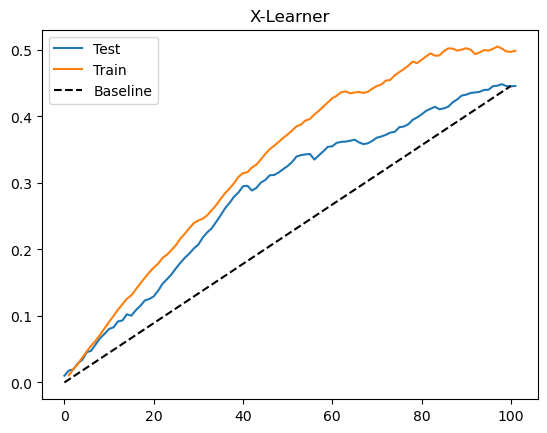

In [24]:
gain_curve_test = cumulative_gain(x_cate_test, "cate", y=y, t=T)
gain_curve_train = cumulative_gain(train.assign(cate=x_cate_train), "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("X-Learner");